In [8]:
import numpy as np
import warnings
import matplotlib.pyplot as plt
import pandas as pd
import ast
import chromoscores.maputils as chrmap
import polychrom
from polychrom.hdf5_format import HDF5Reporter, list_URIs, load_URI, load_hdf5_file
import polychrom.contactmaps

The purpose of this tutorial is to prepare contact maps from simulation trajectories. The functions used in this tutorial are not from the current repository, but from other repositories, mainly polychrom link: https://github.com/open2c/polychrom#

### Loading simulations

In [4]:
path_dict = {}

directory='/project/fudenber_735/polychrom/pds5_wapl_nipbl/layout_with_random_b/'


samples=['LIFETIME_50_SEPARATION_100_RSTALL_0.9_LSTALL_0.0_RC_0.0_LC_0.9_stalldist_1_STEPS_200_velocitymultiplier_1_Tad_1000',
       'LIFETIME_50_SEPARATION_150_RSTALL_0.9_LSTALL_0.0_RC_0.0_LC_0.9_stalldist_1_STEPS_200_velocitymultiplier_1_Tad_1000',
       'LIFETIME_50_SEPARATION_500_RSTALL_0.9_LSTALL_0.0_RC_0.0_LC_0.9_stalldist_1_STEPS_200_velocitymultiplier_1_Tad_1000']

for name in samples:
    path_dict[name] = directory+'simulations/'+name    #directory where each simulation is saved
    print(path_dict[name])


/project/fudenber_735/polychrom/pds5_wapl_nipbl/layout_with_random_b/simulations/LIFETIME_50_SEPARATION_100_RSTALL_0.9_LSTALL_0.0_RC_0.0_LC_0.9_stalldist_1_STEPS_200_velocitymultiplier_1_Tad_1000
/project/fudenber_735/polychrom/pds5_wapl_nipbl/layout_with_random_b/simulations/LIFETIME_50_SEPARATION_150_RSTALL_0.9_LSTALL_0.0_RC_0.0_LC_0.9_stalldist_1_STEPS_200_velocitymultiplier_1_Tad_1000
/project/fudenber_735/polychrom/pds5_wapl_nipbl/layout_with_random_b/simulations/LIFETIME_50_SEPARATION_500_RSTALL_0.9_LSTALL_0.0_RC_0.0_LC_0.9_stalldist_1_STEPS_200_velocitymultiplier_1_Tad_1000


### Making contact maps

Molecular dynamics simulations with Polychrom provide data in hdf5 format, which can be processed to generate contact maps using polychrom function "contactmaps":

In [9]:
mapN = 3000  # Number of monomers to consider when computing contact maps.
mapstarts = np.arange(0, 13500, 1500)  # The monomer number starts.
min_time = 0
skip_freq = 5
refresh = True

# Check if refresh is True and initialize map_dict_eq if necessary
map_dict_eq = {} if refresh else map_dict_eq

for name in samples:
    if name in map_dict_eq:
        print('already')
        continue
    
    URIs = polychrom.hdf5_format.list_URIs(path_dict[name])
    URIs_eq = np.array(URIs)[np.array([int(i.split("::")[-1]) for i in URIs]) > min_time][::skip_freq]
    
    mrc = polychrom.contactmaps.monomerResolutionContactMapSubchains(
        URIs_eq,
        mapstarts,
        mapN,
        cutoff=2.3,
        n=8
    )
    map_dict_eq[name] = mrc
    
# Saving contact maps in numpy .npz format    
for name, mrc in map_dict_eq.items():
    np.savez_compressed(f'maps/{name.split("/")[0]}.npz', mrc)

### Visualizing contact maps

/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log10


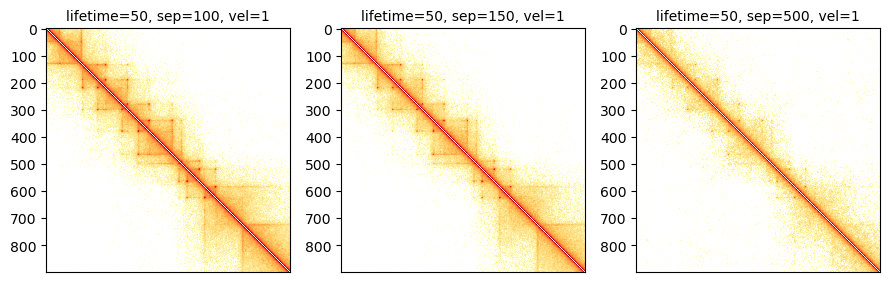

In [23]:
import cooltools
import cooltools.lib.plotting
numx,numy = 3,1
c=0
subplot_width = 3
plt.figure(figsize=(subplot_width*numx,subplot_width*numy))

for name in list(path_dict.keys()):
    params=[ast.literal_eval(i) for i in name.split('/')[0].split('_')[1::2]]
    Lifetime,separation, rstall,lstall,rc,lc,stalldist,steps,velocity,Tad=params
    c+=1
    plt.subplot(numy,numx, c)
    plt.title('lifetime=%s, sep=%s, vel=%s'%(Lifetime,separation,velocity),fontsize=10)
    
    data=np.load(directory+'maps/%s.npz'%name.split('/')[0])
    mrc=data['arr_0']
    mrc  = mrc.astype(float)
    mrc /= np.median(np.diag(mrc,2))
    mat = np.log10(mrc)
    vmax = np.median(np.diag(mat,2))
    vmin = vmax - 3
    
    plt.matshow(mat[1050:1950,1050:1950],cmap='fall',vmin=vmin,vmax=vmax, fignum=False);
    plt.xticks([])
plt.tight_layout()
plt.show()